In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
import joblib
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("../data/heart_disease_cleaned.csv")
print("Loaded shape:", df.shape)
df.head(3)

Loaded shape: (303, 22)


,age,trestbps,chol,thalach,oldpeak,target,target_bin,sex_1.0,cp_2.0,cp_3.0,...,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0
0,0.948726,0.757525,-0.264900,0.017197,1.087338,0,0,True,False,False,...,False,True,False,False,True,False,False,False,True,False
1,1.392002,1.611220,0.760415,-1.821905,0.397182,2,1,True,False,False,...,False,True,True,True,False,False,False,True,False,False
2,1.392002,-0.665300,-0.342283,-0.902354,1.346147,1,1,True,False,False,...,False,True,True,True,False,False,True,False,False,True


In [4]:
 #Remove target columns from features
if "target_bin" not in df.columns:
    raise KeyError("target_bin not found in the cleaned CSV. Please check your cleaned file.")

X = df.drop(columns=["target", "target_bin"], errors="ignore")
y = df["target_bin"]

# Force numeric (booleans -> 0/1, etc.) and fill any rare NaNs
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(0)

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Features shape: (303, 20)
Target distribution:
 target_bin
0    164
1    139
Name: count, dtype: int64


In [5]:
#  Random Forest importance (top 10)
rf_tmp = RandomForestClassifier(random_state=42)
rf_tmp.fit(X, y)

importances = pd.Series(rf_tmp.feature_importances_, index=X.columns).sort_values(ascending=False)
rf_top10 = importances.head(10).index.tolist()

print("Random Forest top 10 features:")
print(rf_top10)

Random Forest top 10 features:
['thalach', 'oldpeak', 'thal_7.0', 'cp_4.0', 'age', 'chol', 'trestbps', 'exang_1.0', 'slope_2.0', 'sex_1.0']


In [6]:
#  RFE (Logistic Regression) - select 10 features
lr_tmp = LogisticRegression(max_iter=1000, solver="liblinear")
rfe = RFE(estimator=lr_tmp, n_features_to_select=10)
rfe.fit(X, y)

rfe_selected = pd.Series(rfe.support_, index=X.columns)
rfe_top = rfe_selected[rfe_selected == True].index.tolist()

print("RFE selected features:")
print(rfe_top)


RFE selected features:
['oldpeak', 'sex_1.0', 'cp_3.0', 'cp_4.0', 'exang_1.0', 'slope_2.0', 'ca_1.0', 'ca_2.0', 'ca_3.0', 'thal_7.0']


In [7]:
#  Chi-Square (requires non-negative features) - top 10
scaler_mm = MinMaxScaler()
X_mm = scaler_mm.fit_transform(X)

chi2_selector = SelectKBest(score_func=chi2, k=10)
chi2_selector.fit(X_mm, y)

chi2_scores = pd.Series(chi2_selector.scores_, index=X.columns).sort_values(ascending=False)
chi2_top10 = chi2_scores.head(10).index.tolist()

print("Chi-Square top 10 features:")
print(chi2_top10)


Chi-Square top 10 features:
['thal_7.0', 'cp_4.0', 'exang_1.0', 'cp_3.0', 'slope_2.0', 'ca_2.0', 'cp_2.0', 'ca_1.0', 'ca_3.0', 'oldpeak']


In [9]:
# Combine the three methods to get final_features automatically
final_features = list(sorted(set(rf_top10) | set(chi2_top10) | set(rfe_top)))
print("Final features (union of RF / Chi2 / RFE):")
print(final_features)
print("\nFinal feature count:", len(final_features))
# Save for traceability
pd.Series(final_features).to_csv("final_features_list.csv", index=False)


Final features (union of RF / Chi2 / RFE):
['age', 'ca_1.0', 'ca_2.0', 'ca_3.0', 'chol', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'exang_1.0', 'oldpeak', 'sex_1.0', 'slope_2.0', 'thal_7.0', 'thalach', 'trestbps']

Final feature count: 15


In [10]:
#  Train/test split using final features
X_final = X[final_features].copy()
y_final = y.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (242, 15) X_test: (61, 15)


In [11]:
#  Helper to evaluate models and plot ROC
def evaluate_model(name, model, X_test, y_test, plot_roc=True):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # Some models (like SVC without probability) fall back to decision_function
        try:
            y_proba = model.decision_function(X_test)
            # scale to 0-1
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-8)
        except Exception:
            y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"\n{name} — accuracy: {acc:.4f}, precision: {prec:.4f}, recall: {rec:.4f}, f1: {f1:.4f}, roc_auc: {roc_auc:.4f}" if roc_auc else f"\n{name} — accuracy: {acc:.4f}, precision: {prec:.4f}, recall: {rec:.4f}, f1: {f1:.4f}")

    if plot_roc and (y_proba is not None):
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
        plt.plot([0,1], [0,1], "--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve — {name}")
        plt.legend()
        plt.show()

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc_auc}

In [12]:
#  Containers for models and results
models = {}
results = {}

In [13]:
#  Train Logistic Regression
model_lr = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced", random_state=42)
model_lr.fit(X_train, y_train)

models["Logistic Regression"] = model_lr
print("Trained Logistic Regression")

Trained Logistic Regression



Logistic Regression — accuracy: 0.8852, precision: 0.8182, recall: 0.9643, f1: 0.8852, roc_auc: 0.9632


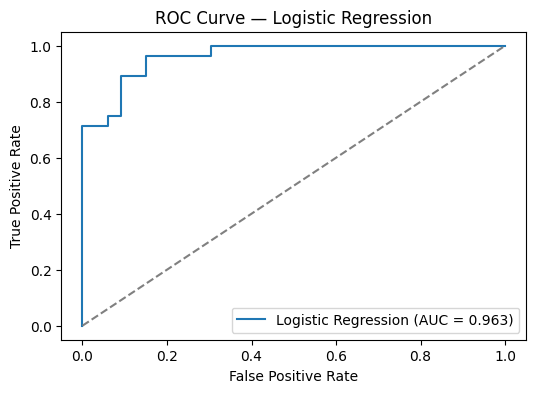

In [14]:
#  Evaluate Logistic Regression
results["Logistic Regression"] = evaluate_model("Logistic Regression", models["Logistic Regression"], X_test, y_test)


In [15]:
#  Train Decision Tree
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

models["Decision Tree"] = model_dt
print("Trained Decision Tree")


Trained Decision Tree



Decision Tree — accuracy: 0.7705, precision: 0.7188, recall: 0.8214, f1: 0.7667, roc_auc: 0.7744


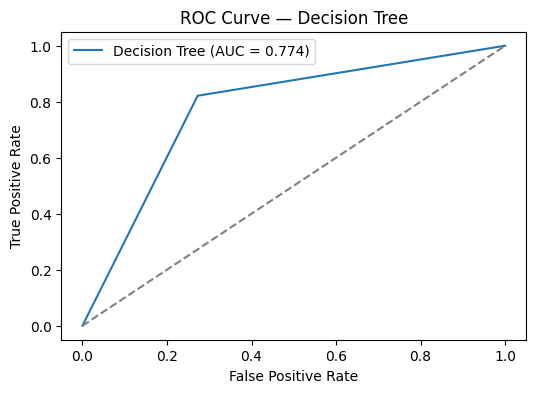

In [16]:
#  Evaluate Decision Tree
results["Decision Tree"] = evaluate_model("Decision Tree", models["Decision Tree"], X_test, y_test)


In [17]:
#  Train Random Forest
model_rf = RandomForestClassifier(n_estimators=200, random_state=42)
model_rf.fit(X_train, y_train)

models["Random Forest"] = model_rf
print("Trained Random Forest")


Trained Random Forest



Random Forest — accuracy: 0.9016, precision: 0.8667, recall: 0.9286, f1: 0.8966, roc_auc: 0.9481


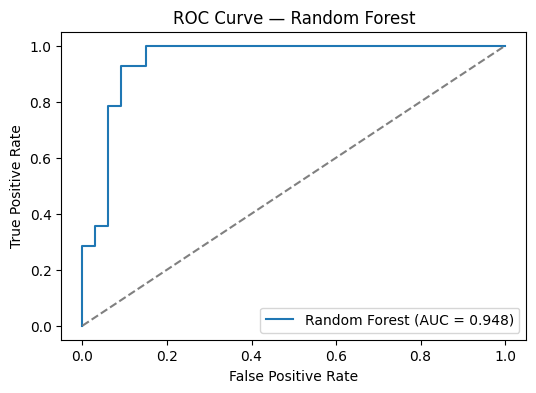

In [18]:
#  Evaluate Random Forest
results["Random Forest"] = evaluate_model("Random Forest", models["Random Forest"], X_test, y_test)


In [19]:
#  Train SVM (probabilities enabled)
model_svc = SVC(probability=True, kernel="rbf", random_state=42)
model_svc.fit(X_train, y_train)

models["SVM"] = model_svc
print("Trained SVM")


Trained SVM



SVM — accuracy: 0.9344, precision: 0.9000, recall: 0.9643, f1: 0.9310, roc_auc: 0.9762


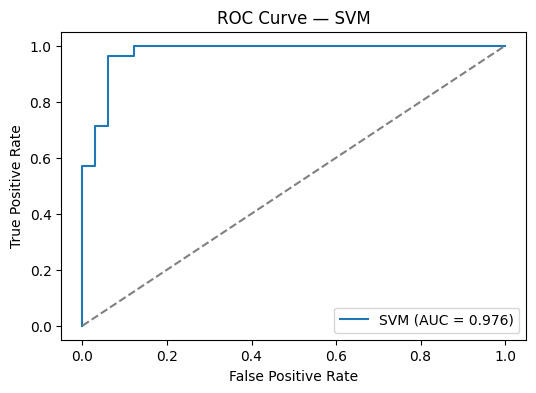

In [20]:
#  Evaluate SVM
results["SVM"] = evaluate_model("SVM", models["SVM"], X_test, y_test)


In [21]:
#  Compare and save the best model (by roc_auc if available, else by f1)
# Convert None roc_auc to -1 so comparison works
scores_for_rank = {k: (v["roc_auc"] if v["roc_auc"] is not None else v["f1"]) for k, v in results.items()}
best_name = max(scores_for_rank, key=lambda k: scores_for_rank[k])

print("All results summary:")
for k,v in results.items():
    print(k, v)

print("\nBest model according to the chosen metric:", best_name)

# Save the best model
MODEL_DIR = "../models"
import os
os.makedirs(MODEL_DIR, exist_ok=True)
best_model_path = os.path.join(MODEL_DIR, f"{best_name.replace(' ', '_')}.joblib")
joblib.dump(models[best_name], best_model_path)
print("Saved best model to:", best_model_path)

# Also save the results table
pd.DataFrame(results).T.to_csv("supervised_results_summary.csv")
print("Saved results summary to supervised_results_summary.csv")


All results summary:
Logistic Regression {'accuracy': 0.8852459016393442, 'precision': 0.8181818181818182, 'recall': 0.9642857142857143, 'f1': 0.8852459016393442, 'roc_auc': np.float64(0.9632034632034633)}
Decision Tree {'accuracy': 0.7704918032786885, 'precision': 0.71875, 'recall': 0.8214285714285714, 'f1': 0.7666666666666667, 'roc_auc': np.float64(0.7743506493506493)}
Random Forest {'accuracy': 0.9016393442622951, 'precision': 0.8666666666666667, 'recall': 0.9285714285714286, 'f1': 0.896551724137931, 'roc_auc': np.float64(0.948051948051948)}
SVM {'accuracy': 0.9344262295081968, 'precision': 0.9, 'recall': 0.9642857142857143, 'f1': 0.9310344827586207, 'roc_auc': np.float64(0.9761904761904762)}

Best model according to the chosen metric: SVM
Saved best model to: ../models\SVM.joblib
Saved results summary to supervised_results_summary.csv
